# Tunisian Horses - Only stills

## Create metadata

In [162]:
import shutil
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

import tensorflow as tf
import tf_keras as keras
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# import tensorflow.keras as keras
from tf_keras.utils import to_categorical
from tf_keras.models import Sequential
from tf_keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tf_keras import Input

print(f"keras: {keras.__version__}")
print(f"backend: {keras.backend.backend()}")

keras: 2.18.0
backend: tensorflow


In [163]:

# 2. Prepare data for model training:
# Base path to the database
base_dir = '../data/THoDBRL2015'

metadata = []

# Consolidate images into a training directory
output_train_dir = os.path.join(base_dir, 'training_data')

os.makedirs(output_train_dir, exist_ok=True)

parts = [
    'Part1', 
    # 'Part2', 
    # 'Part3', 
    # 'Part4', 
    # 'Part5'
]

# Iterate through each Part folder
for part in parts:
    videos_dir = os.path.join(base_dir, part, 'videos')

    for horse_id_folder in os.listdir(videos_dir):
        horse_path = os.path.join(videos_dir, horse_id_folder)

        if os.path.isdir(horse_path):  # Ensure it's a directory
            # Find all stills folders (e.g., images, images1, images2, etc.)
            for stills_folder in os.listdir(horse_path):
                stills_path = os.path.join(horse_path, stills_folder)

                if os.path.isdir(stills_path) and stills_folder.startswith('images'):  # Check for folders named 'images*'
                    target_dir = os.path.join(output_train_dir, f'horse_{horse_id_folder}')

                    os.makedirs(target_dir, exist_ok=True)
                    
                    # Copy all image files from the stills folder to the target directory
                    for img_file in os.listdir(stills_path):
                        img_path = os.path.join(stills_path, img_file)

                        if img_file.endswith(('.jpg', '.jpeg', '.png')):  # Ensure it's an image file
                            metadata.append({
                                'horse_id': horse_id_folder,
                                'image_path': img_path,
                                'width': Image.open(img_path).size[0],
                                'height': Image.open(img_path).size[1],
                            })
                        
                            # shutil.copy(img_path, target_dir)

                    # print(f"Copied images from {stills_path} to {target_dir}")

# Create DataFrame with specified dtypes
metadata_df = pd.DataFrame(metadata, dtype='object').astype({
    'horse_id': 'int64',          # Assuming it's an integer
    'image_path': 'string',
    'width': 'int64',
    'height': 'int64',
})




## Descriptive Analysis

In [164]:
print(f"Total images: {len(metadata_df)}")
print(f"Total horses: {metadata_df['horse_id'].nunique()}")
print(f"Width: {metadata_df['width'].unique()}")
print(f"Height: {metadata_df['height'].unique()}")


Total images: 10364
Total horses: 10
Width: [640]
Height: [480]


In [165]:
print(metadata_df[:5])

   horse_id                                         image_path  width  height
0         9  ../data/THoDBRL2015/Part1/videos/9/images1/img...    640     480
1         9  ../data/THoDBRL2015/Part1/videos/9/images1/img...    640     480
2         9  ../data/THoDBRL2015/Part1/videos/9/images1/img...    640     480
3         9  ../data/THoDBRL2015/Part1/videos/9/images1/img...    640     480
4         9  ../data/THoDBRL2015/Part1/videos/9/images1/img...    640     480


In [166]:
grouped_horse = metadata_df.groupby(['horse_id'], observed=True)

grouped_horse.describe()

width                                                 height  \
           count   mean  std    min    25%    50%    75%    max   count   
horse_id                                                                  
1         1415.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  1415.0   
2         1029.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  1029.0   
3         1282.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  1282.0   
4         1173.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  1173.0   
5          548.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0   548.0   
6          729.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0   729.0   
7         1226.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  1226.0   
8         1262.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  1262.0   
9          585.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0   585.0   
10        1115.0  640.0  0.0  640.0  640.0  640.0  640.0  640.0  1115.0   

                                                         
           mean  std    min    25%    50%    75%    max  
horse_id                                                 
1         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
2         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
3         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
4         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
5         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
6         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
7         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
8         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
9         480.0  0.0  480.0  480.0  480.0  480.0  480.0  
10        480.0  0.0  480.0  480.0  480.0  480.0  480.0

In [167]:
# Images per horse id
grouped_horse.size().agg(['min', 'max', 'mean'])

min      548.0
max     1415.0
mean    1036.4
dtype: float64

In [168]:
df = pd.DataFrame(metadata_df)

## Prepare dataset

In [169]:
# For splitting data
# Load data
# Prepare dataset
def load_images_and_labels(metadata_df):
    images = []
    labels = []
    resize_value = (128, 128)
    # resize_value = (224, 224) # ResNet50 default input size

    
    for _, row in metadata_df.iterrows():
        if os.path.exists(row['image_path']):
            img = Image.open(row['image_path']).resize(resize_value)  # Scale to same size
            images.append(np.array(img))
            labels.append(row['horse_id'])  # use horse_id for the label
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels
    


In [170]:
# Load data
images, labels = load_images_and_labels(metadata_df)


### Split in train, validation and test

In [171]:
# Step 1: Split into Temporary (Train + Validation) and Test
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [172]:
# Step 2: Split Temporary (Train + Validation) into Train and Validation
X_train, X_validation, y_train, y_validation = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

In [173]:
X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((6632, 128, 128, 3),
 (1659, 128, 128, 3),
 (2073, 128, 128, 3),
 (6632,),
 (1659,),
 (2073,))

In [174]:
# Normalise pixelvalues
# X_train = X_train / 255.0
# X_test = X_test / 255.0

# Transfer labels to category data
# num_classes = len(metadata_df['horse_id'].unique())
num_classes = len(np.unique(labels))

# 0-based index
y_train = y_train - 1  # If needed then custumize labels (sometimes gives error)
y_test = y_test - 1  # The same for test
y_validation = y_validation - 1  # The same for validation

# print(y_train.min())  # Min label value
# print(y_train.max())  # Max label value

# Convert labels to categorical data
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_validation = to_categorical(y_validation, num_classes)

In [175]:
# Normalise pixel values?

## Define CNN

### Custom CNN: Sequential Keras

In [176]:


def create_custom_model():
    model = Sequential()

    INPUT_SHAPE = (128, 128, 3)
    # INPUT_SHAPE = (224, 224, 3) # Default for ResNet50

    # Add layers step-by-step
    # model.add(Input(shape=INPUT_SHAPE))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # To prevent overfitting

    model.add(Dense(num_classes, activation='softmax'))  # Output layer
    
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model



### ResNet

In [177]:
def create_resnet_model():
    INPUT_SHAPE = (128, 128, 3)
    model = keras.applications.ResNet50(
        include_top=True, weights=None, input_tensor=None, input_shape=INPUT_SHAPE,
        pooling=None, classes=num_classes
    )

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Create model

In [178]:
# Create a model
# model = create_custom_model()
model = create_resnet_model()

# Model summary
model.summary()
# Sequential model: No “connected to” column. The model is linearly connected layer by layer.

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [179]:
model.save("model.h5")
import h5py

# Load the HDF5 file
with h5py.File('model.h5', 'r') as f:
    keras_version = f.attrs.get('keras_version')
    print(f"Keras Version: {keras_version}")

/Users/thijs/fontys/dasc2/HorseFace/venv_horseface/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Keras Version: 2.18.0


In [180]:
y_train.shape
# y_train[:5]

(6632, 10)

In [181]:
history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_data=(X_validation, y_validation)
)


208/208 [==============================] - 470s 2s/step - loss: 0.3465 - accuracy: 0.9012 - val_loss: 4.8256 - val_accuracy: 0.3900


Findings with epochs=10 and batch_size=32
- expected time (335 sec * 10 epochs) ~~ 1 hour
- Accuracy in 1st epoch: 0.54, and loss 3.92
- Accuracy in 2nd epoch: on the start already accuracy of 0.91
- In 2nd epoch, no big changes.

Findings with epochs=1 and batch_size=64
- expected time ~6 min (so same time per epoch)
- accuracy is >0.95.

Explanation:
- 

## Save model

In [182]:
# Save the entire model as a `.keras` zip archive.
model.save('../data/saved_models/my_model_epoch_1_batch_size_128.keras')

## Accuracy

In [183]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

65/65 [==============================] - 28s 421ms/step - loss: 4.8271 - accuracy: 0.3874
Test Loss: 4.827070236206055
Test Accuracy: 0.3873613178730011


## Confusion matrix

(2073, 128, 128, 3)
65/65 [==============================] - 28s 429ms/step


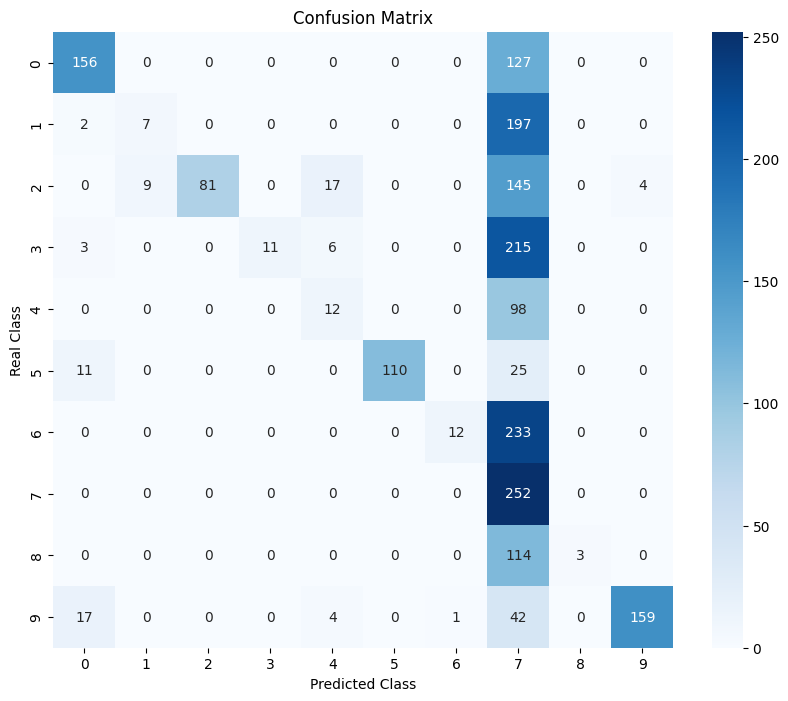

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = [str(i) for i in range(metadata_df['horse_id'].nunique())]  

# predict the labels for testset
print(X_test.shape)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot The confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix')
plt.show()

## GradCAM
GradCAM = Gradient-Weighted Class Activation Mapping

Use GradCAM to visualize the areas of the image that the model is looking at when making predictions.
We use the last convolutional layer of the model as the last layer before the output layer.
We use `tf-explain` to generate the GradCAM heatmap.

In [185]:
# Load pretrained model or your own
# model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)
from tf_explain.core.grad_cam import GradCAM
import numpy as np

In [186]:
model.built

True

In [187]:
if model.input is None:
    print("The model is not connected to an input.")
else:
    print(f"Input shape: {model.input.shape}")

Input shape: (None, 128, 128, 3)


In [188]:
print(f"Outer model input shape: {model.input.shape}")

Outer model input shape: (None, 128, 128, 3)


In [189]:
if model.built:
    print("The model is connected to an input.")
else:
    print("The model is not connected to an input.")

The model is connected to an input.


In [190]:
for layer in model.layers:
    if hasattr(layer, 'output'):
        print(f"Layer {layer.name} is connected with output shape {layer.output.shape}")
    else:
        print(f"Layer {layer.name} is not connected.")

Layer input_2 is connected with output shape (None, 128, 128, 3)
Layer conv1_pad is connected with output shape (None, 134, 134, 3)
Layer conv1_conv is connected with output shape (None, 64, 64, 64)
Layer conv1_bn is connected with output shape (None, 64, 64, 64)
Layer conv1_relu is connected with output shape (None, 64, 64, 64)
Layer pool1_pad is connected with output shape (None, 66, 66, 64)
Layer pool1_pool is connected with output shape (None, 32, 32, 64)
Layer conv2_block1_1_conv is connected with output shape (None, 32, 32, 64)
Layer conv2_block1_1_bn is connected with output shape (None, 32, 32, 64)
Layer conv2_block1_1_relu is connected with output shape (None, 32, 32, 64)
Layer conv2_block1_2_conv is connected with output shape (None, 32, 32, 64)
Layer conv2_block1_2_bn is connected with output shape (None, 32, 32, 64)
Layer conv2_block1_2_relu is connected with output shape (None, 32, 32, 64)
Layer conv2_block1_0_conv is connected with output shape (None, 32, 32, 256)
Layer c

In [191]:
for layer in model.layers:
    print(layer.output.shape)

(None, 128, 128, 3)
(None, 134, 134, 3)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 64, 64, 64)
(None, 66, 66, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)
(No

In [192]:
def infer_grad_cam_target_layer_modified(model):
        """
        Search for the last convolutional layer to perform Grad CAM, as stated
        in the original paper.

        Args:
            model (tf.keras.Model): tf.keras model to inspect

        Returns:
            str: Name of the target layer
        """
        for layer in reversed(model.layers):
            # Select closest 4D layer to the end of the network.
            if len(layer.output.shape) == 4:
                return layer.name

        raise ValueError(
            "Model does not seem to contain 4D layer. Grad CAM cannot be applied."
        )

In [205]:
# Example data
image = np.random.random((1, 28, 28))  # Single grayscale image
label = np.array([1])  # Class label

target_layer = infer_grad_cam_target_layer_modified(model)
print(f"Target layer: {target_layer}")

# LAYER_NAME = "conv5_block3_3_conv" # The last convolutional layer
LAYER_NAME = "conv2_block1_1_conv" # The last convolutional layer

# Grad-CAM visualization
explainer = GradCAM()
# required positional arguments: 'validation_data', 'model', and 'class_index'
# layer_name is optional: tf-learn selects closest 4D layer to the end of the network. ACHTUNG: tf-learn has compatibility issues with tf2.0
VALIDATION_DATA = (image, label)

print(f"model inputs shape: {model.inputs}")
KerasTensor = tf.keras.Input(shape=(128, 128, 3))
print(f"KerasTensor: {KerasTensor}")
grid = explainer.explain(validation_data=VALIDATION_DATA, model=model, class_index=10, layer_name=LAYER_NAME)

Target layer: conv5_block3_out
model inputs shape: [<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_2')>]
KerasTensor: <KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=False, name=keras_tensor_814>


ValueError: All `inputs` values must be KerasTensors. Received: inputs=[[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_2')>]] including invalid value KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") of type <class 'tf_keras.src.engine.keras_tensor.KerasTensor'>

Error 30 December when using custom-model:

ValueError: All `inputs` values must be KerasTensors. Received: inputs=[[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'conv2d_3_input')>]] including invalid value KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='conv2d_3_input'), name='conv2d_3_input', description="created by layer 'conv2d_3_input'") of type <class 'tf_keras.src.engine.keras_tensor.KerasTensor'>


In [ ]:


# Assuming df is already defined and contains the image paths
IMAGE_PATH = df['image_path'][300]


# Load a sample image (or multiple ones)
img = keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(128, 128))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Expand to 4D tensor
img = img / 255.0  # Normalize if required

# Ensure the model is called with input data
prediction = model.predict(img)
class_index = np.argmax(prediction, axis=1)[0]  # Get the predicted class

# Prepare data for GradCAM
data = (img, None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=class_index, layer_name=LAYER_NAME)

# Save the GradCAM result
explainer.save(grid, ".", "grad_cam.png")


Visualise the 

Error when using custom model:
AttributeError: The layer sequential_2 has never been called and thus has no defined output.


In [ ]:

# Load the original image for overlay
original_img = Image.open(IMAGE_PATH).resize((128, 128))

# Create a heatmap from GradCAM output
plt.figure(figsize=(8, 8))

# Plot heatmap
plt.subplot(1, 2, 1)
plt.title("GradCAM Heatmap")
plt.imshow(grid, cmap='jet')
plt.axis('off')

# Overlay heatmap on the original image
plt.subplot(1, 2, 2)
plt.title("Overlayed Heatmap")
plt.imshow(original_img)
plt.imshow(grid, cmap='jet', alpha=0.5)  # Adjust alpha for transparency
plt.axis('off')

# Show the results
plt.tight_layout()
plt.show()